In [1]:
import gym
import gym_oscillator
import oscillator_cpp
from stable_baselines.common import set_global_seeds

from stable_baselines.common.policies import MlpPolicy,MlpLnLstmPolicy,FeedForwardPolicy
from stable_baselines.common.vec_env import DummyVecEnv,SubprocVecEnv,VecNormalize, VecEnv
from stable_baselines import PPO2
from stable_baselines.common.vec_env import VecEnv

import numpy as np
from matplotlib import pyplot as plt



/home/dmitriy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dmitriy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dmitriy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dmitriy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

In [2]:
def make_env(env_id, rank, seed=0,):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    :param s_i: (bool) reward form, only one can be true
    """
    def _init():
        env = gym.make(env_id)
        print(env.reset().shape)
        return env
    set_global_seeds(seed)
    return _init

### To train with stablebaselines

In [3]:
#Our env
env_id = 'oscillator-v0'
time_steps = int(10e6)
#Number of cpus
num_cpu = 8
env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])

model = PPO2(MlpPolicy, env, verbose=1,tensorboard_log="MLP/")
#model.learn(time_steps)

(250,)
(250,)
(250,)
Instructions for updating:
Use keras.layers.flatten instead.
(250,)
(250,)
(250,)
(250,)
(250,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Save

In [4]:
# model.save('trained_models/model5layers.tf')

### Load model

In [5]:
env_id = 'oscillator-v0'
env = gym.make(env_id)
#Number of cpus
num_cpu = 1

env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])
model = PPO2(MlpPolicy, env, verbose=1,tensorboard_log="MLP/")
model = model.load('trained_models/Ps6_final_3')

(250,)
Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [8]:
env = gym.make(env_id)
#Store rewards
rews_ = []
#Store observations
obs_ = []
obs = env.reset()
#Store actions
acs_ = []
#Store X,Y according to 
states_x = []
states_y = []

#Initial, non-suppresssion 
for i in range(25000):
    obs, rewards, dones, info = env.step([0])
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(0)
    rews_.append(rewards)

#Suppression stage
for i in range(25000):
    action, _states = model.predict(obs)
   
    obs, rewards, dones, info = env.step(action)
   
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(action)
    rews_.append(rewards)

#Final relaxation
for i in range(5000):
    obs, rewards, dones, info = env.step([0])
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(0)
    rews_.append(rewards)


### Graph plot

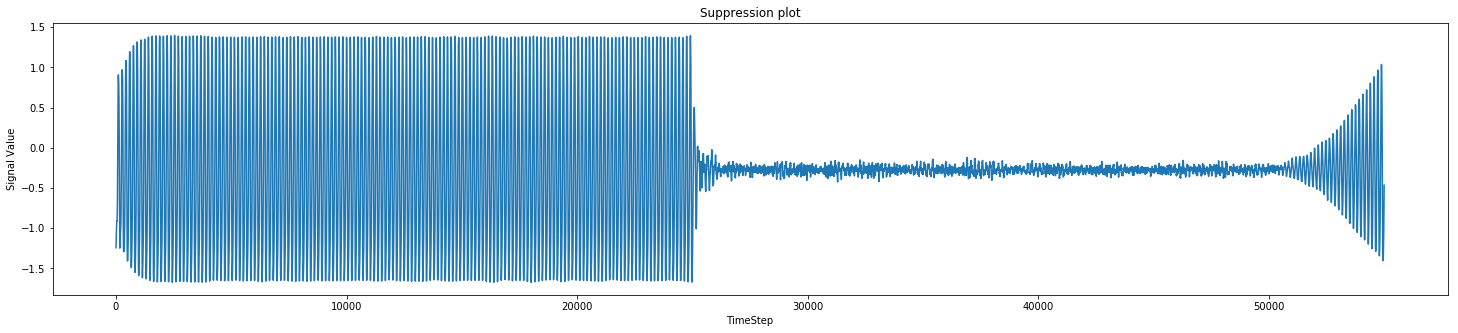

In [9]:
plt.figure(figsize=(25,5))
plt.title('Suppression plot')
plt.xlabel('TimeStep')
plt.ylabel('Signal Value')
plt.plot(states_x)

### Model score:

In [12]:
print(np.std(states_x[5000:25000])/np.std(states_x[30000:45000]))
s = (np.std(states_x[5000:25000])/np.std(states_x[30000:45000]))
print(np.sqrt(s))

27.266212742105157
5.22170592259897


In [11]:
print(np.mean(states_x[5000:150000]))

-0.2683076704695317


In [31]:
np.sqrt(1.10554209724429/0.0367348421348131)

5.48590841941973